# Figure 4 Final

Notebook to make data for figure 4 for ms <br>
by Cascade Tuholske 2020.02.23

In [1]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [2]:
#### Load Data
# file path
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# HI DATA
FN_IN = 'processed/AllDATA-GHS-ERA5-HI406-PDAYS.csv'
HI_STATS = pd.read_csv(DATA_IN+FN_IN)

# File out
FN_OUT = 'processed/AllDATA-GHS-ERA5-HI406-ZSCORES.csv'

# scale the date in the plot 
scale = 10**9 

In [3]:
# Drop IDs where days 1983 = 1 with none else. throws error in regressions 

print(len(HI_STATS))
only83 = HI_STATS.groupby('ID_HDC_G0')['total_days'].sum() == 1 # sum up total days and find those with 1 day
only83 = list(only83[only83 == True].index) # make a list of IDs
sub = HI_STATS[HI_STATS['ID_HDC_G0'].isin(only83)] # subset those IDs
bad_ids = sub[(sub['year'] == 1983) & (sub['total_days'] == 1)] # drop those from 1983 only
drop_list = list(bad_ids['ID_HDC_G0']) # make a list
HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)] # drop those from the list
print(len(HI_STATS))

390524
390354


In [4]:
#### Add In Meta Data
geog = ['region', 'intermediate-region', 'sub-region','CTR_MN_NM', 'ID_HDC_G0', 'GCPNT_LAT', 'GCPNT_LON']
meta_fn = 'processed/AllDATA-GHS-ERA5-HI406-META.csv'
all_data = pd.read_csv(DATA_IN+meta_fn)
meta = all_data[geog]
meta = meta.drop_duplicates('ID_HDC_G0')

## Merge in meta
HI_STATS = HI_STATS.merge(meta, on = 'ID_HDC_G0', how = 'left')

In [5]:
def z_score(data):
    "mini function to make z scoares"
    mean = np.mean(data)
    sd = np.std(data)
    zscores = (data - mean) / sd
    
    return zscores

In [6]:
def z_residuals(data, col):
    
    """ function finds the z_scores of the residuals from a linear regession.
    Currently set up for city-leve z-scores of the total days per year
    >40.6C. Returns two lists, z-scores for each city and the years for ease
    of plotting.
    
    Args: 
        data = all data
        col = column to regress and fine z-score of residuals of, using 'total_days'
    """
    
    years_list = []
    zscores_list = []
    
    years = list(np.unique(data.sort_values('year')['year']))

    for i, city_df in enumerate(data.groupby('ID_HDC_G0')):
        total_days = list(city_df[1].sort_values('year')[col].values)
    
        # Get Data
        X_year = years
        Y_stats = total_days

        # Add Intercept
        X_year_2 = sm.add_constant(X_year)

        # Regress
        model = sm.OLS(Y_stats, X_year_2).fit()

        # residual Z scores 
        zscores = z_score(model.resid) 

        zscores_list.append(zscores)
        years_list.append(years)
        
    return years_list, zscores_list

In [7]:
#### Write Out All Data -- Can subset later
data = HI_STATS
years = list(np.unique(data.sort_values('year')['year']))
cols = ['ID_HDC_G0']+years
zscores_df = pd.DataFrame(columns = cols)

In [8]:
#### Write a loop to get scores
row = [] # empty list for rows
years = list(np.unique(data.sort_values('year')['year'])) # get years

for i, city_df in enumerate(data.groupby('ID_HDC_G0')):
    total_days = list(city_df[1].sort_values('year')['total_days'].values)

    # Get Data
    city_id = [city_df[0]]
    X_year = years
    Y_stats = total_days

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit()

    # residual Z scores 
    zscores = z_score(model.resid) 
    
    # Add to data frame
    row = city_id + list(zscores) # tag on the z-scores
    row = pd.Series(row, index = zscores_df.columns)
    
    # append the df
    zscores_df = zscores_df.append(row, ignore_index=True)

In [9]:
#### Add in Meta Data
df_out = zscores_df.merge(meta, on = 'ID_HDC_G0', how = 'left')

In [10]:
#### Save Out
# FN_OUT = 'processed/AllDATA-GHS-ERA5-HI406-ZSCORES.csv'
df_out.to_csv(DATA_IN+FN_OUT)

## Find hot years

In [11]:
#### Make Function to scatter plot all z-scores
def z_scatter(years_list, zscores_list, year, alpha1, alpha2):
    "scatter plot of z-scores across years, with select year highlighted"
    
    index = 34 - (2016 - year) - 1 # finds index for a given year in the z-score list
    
    # Get year to highlight 
    yr = []
    for year in years_list:
        yr.append(year[index])

    zs = []
    for z in zscores_list:
        zs.append(z[index])
            
    #### Plot All z-scores
    plt.scatter(years_list, zscores_list, alpha = alpha1, marker = "o")
    plt.scatter(yr, zs, color = 'red', alpha = alpha2, marker = "o")
    plt.hlines(0, 1983, 2016, linewidths = 3)
    plt.title('Z-scores for total days for '+location)
    plt.xlabel('year')
    plt.ylabel('z-score')

In [12]:
#### Make Function to hist z-scores for a given year
def z_year_hist(z_list, year, alpha, color):
    "plots the distribution of z scores for a given year"
    index = 34 - (2016 - year) - 1 # finds index for a given year in the z-score list
    z_year = []
    for z in zscores_list:
        score = z[index]
        z_year.append(score)
    
    plt.hist(z_year, alpha = alpha, color = color, density=True)


In [13]:
#### Select Geography
location = 'France'
geog = 'CTR_MN_NM'
year = 2003
data = HI_STATS[HI_STATS[geog] == location]

In [14]:
#### Find Z-scores
years_list, zscores_list = z_residuals(data, 'total_days')

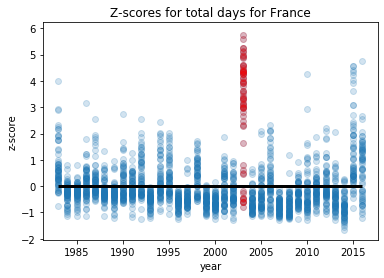

In [15]:
z_scatter(years_list, zscores_list, year, 0.2, 0.2)
plt.savefig(FIG_OUT+"Z-scores_all_"+location, dpi = 300, bbox_inches='tight')

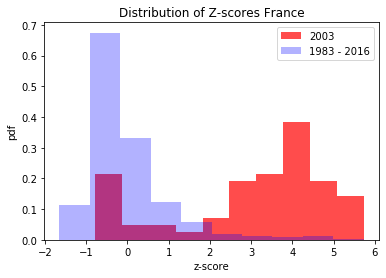

In [16]:
z_year_hist(zscores_list, year, .7, color = 'red');

flat_list = []
for sublist in zscores_list:
    for item in sublist:
        flat_list.append(item)
plt.hist(flat_list, alpha = 0.3, color = 'blue', density=True)
plt.title('Distribution of Z-scores '+location)
plt.xlabel('z-score')
plt.ylabel('pdf')

# Legend
labels = [year, '1983 - 2016']
plt.legend(labels)
plt.savefig(FIG_OUT+"Z-scores_dist_"+location, dpi = 300, bbox_inches='tight')